# Deep Semi-supervised Anomaly Detection

This script demonstrates so called Deep Semi-Supervised Anomaly Detection (SAD) presented in paper *Ruff et. al. , Deep Semi-Supervised Anomaly Detection*

This work assumes that we also know very few labels. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision.datasets import EMNIST
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm


def show_score_map(model, X):
    xr = torch.linspace(X[:,0].min(), X[:,0].max(), 100)
    yr = torch.linspace(X[:,1].min(), X[:,1].max(), 100)
    x_, y_ = torch.meshgrid(xr, yr)
    X_ = torch.cat((x_.reshape((-1,1)), y_.reshape(-1,1)),1)
    with torch.no_grad():
        s_ = model(X_).reshape(len(xr), len(yr))
        plt.imshow(s_.T, cmap = 'jet')
        plt.title('score')
        plt.xlabel('x axis')
        plt.ylabel('y axis')
        plt.show()
        plt.imshow(np.log(s_.T), cmap = 'jet')
        plt.title('log score')
        plt.xlabel('x axis')
        plt.ylabel('y axis')
        plt.show()

def roc(y, N = 100, display = True):
    T = torch.linspace(0, y.max(), N)
    tpr, fpr = [],[]
    for T_ in T:
        yt = torch.tensor([(-1 if y_ else 1) for y_ in y > T_])
        tpr.append(torch.logical_and(yt == -1, l == -1).sum() / (l == -1).sum())  
        fpr.append(torch.logical_and(yt == -1, l == 1).sum() / (l == 1).sum())
    if display:
        plt.plot(fpr, tpr, '--')
        plt.xlabel('false positive ratio (FP / N)')
        plt.ylabel('true positive ratio (TP / P)')
        plt.show()
    return tpr, fpr

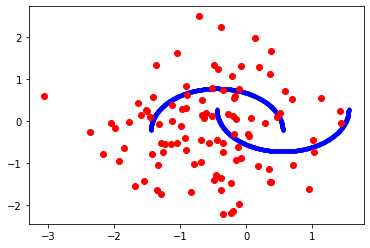

In [ ]:
np.random.seed(42)
from sklearn.datasets import make_moons
Xn = make_moons(n_samples=1000, noise=False, random_state=42)[0]
Xa = np.random.randn(100,2)
'''
Xn1 = np.random.rand(10000,2) - 0.5
Xn2 = (np.random.rand(30000,2) - 2) * 0.5
Xa = 2 * (np.random.rand(200,2) - 0.5)
Xn = np.concatenate((Xn1,Xn2))
'''
X = np.concatenate((Xn,Xa))
X -= X.mean(0) 

l = torch.cat((torch.ones(Xn.shape[0]), -torch.ones(Xa.shape[0])))

plt.plot(X[l==1,0],X[l==1,1],'b.')
plt.plot(X[l==-1,0],X[l==-1,1],'ro')
# plt.title('Generated Samples')
plt.show()

### Network Definition and Tranining


  0%|          | 0/1000 [00:00<?, ?it/s]

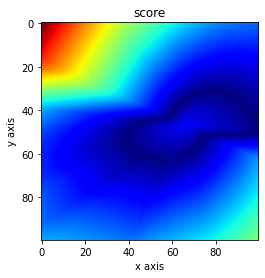

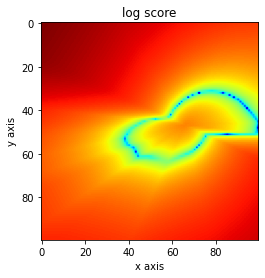

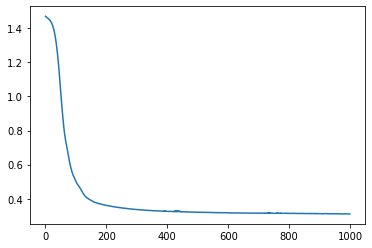

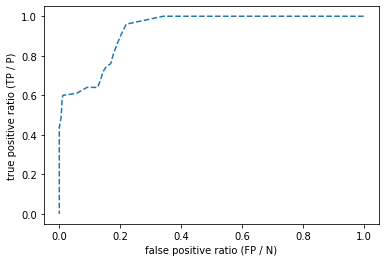

In [ ]:
torch.manual_seed(42)

class LinearOneClass(nn.Module):
    '''
     Linear(2,32) -> ReLU() -> Linear(32,16) -> ReLU() -> Linear(16,8) ->
       ReLU() -> Linear(8,4) -> s = |x-c|_2
    '''
    def __init__(self, dropout_p = 0.0):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 64, bias = False),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 32, bias = False),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32,16, bias = False),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(16,8, bias = False),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(8,4, bias = False))
        
        self.c = torch.randn((1,4))
    
    def phi(self, x):
        '''
        just projecting datapoints x to the feature space
        '''
        return self.network(x)
    def forward(self, x):
        ''' 
        points are projected to the feature space (4D) and then their projection is substracted from the 
        hypersphere center $c$
        '''
        x = self.phi(x)
        return torch.linalg.vector_norm(x - self.c,dim = -1)
        
epochs = 1000
model = LinearOneClass()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses = []
for epoch in tqdm(range(epochs)):
    # anomaly score
    s = model(torch.tensor(X).float())
    
    # tranining 
    loss = (s ** l).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
show_score_map(model, X)
plt.plot(losses)
plt.show()
tpr, fpr = roc(model(torch.tensor(X).float()).detach())

In [ ]:
torch.save({'fpr' : fpr, 'tpr' : tpr, 'X' : X , 'l' : l, 'model' : model.state_dict()}, 'SAD.torch')

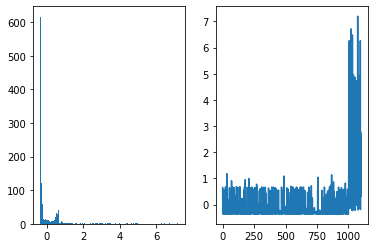

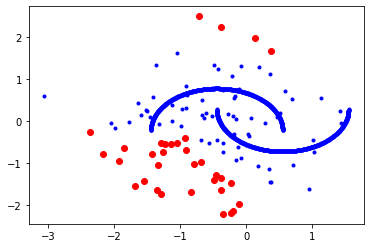

In [ ]:
with torch.no_grad():
    s = model(torch.tensor(X).float())
    anomalies = (s - s.mean()) > 2
    plt.subplot(121)
    plt.hist(s-s.mean(),128)
    plt.subplot(122)
    plt.plot(s-s.mean())
    plt.show()
    plt.plot(X[~anomalies,0],X[~anomalies,1],'b.')
    plt.plot(X[anomalies,0],X[anomalies,1],'ro')
    plt.show()

# Example with training MNIST & EMNIST


---



In [ ]:
train_loader = torch.utils.data.DataLoader(
  MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 # (0.1307,), (0.3081,))
                                 (0.5),(0.5,))
                             ])),
  batch_size=1024, shuffle = True)

train_loader_anomaly = torch.utils.data.DataLoader(
    EMNIST(root="files/", split="byclass", download=True, train=True, 
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5),(0.5,))
                ])),
    batch_size=128, shuffle = True)

  0%|          | 0/10 [00:00<?, ?it/s]

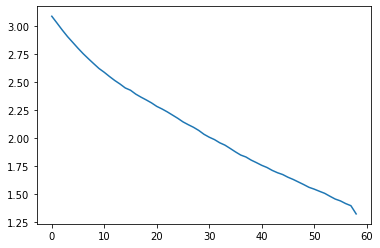

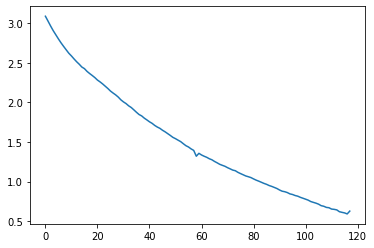

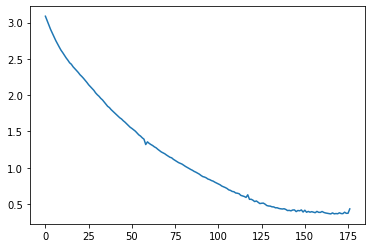

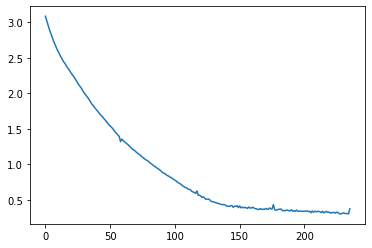

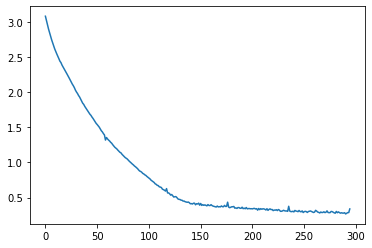

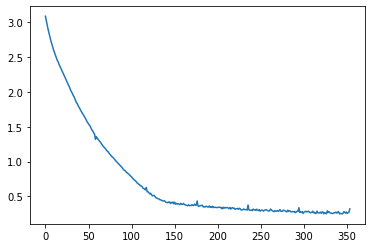

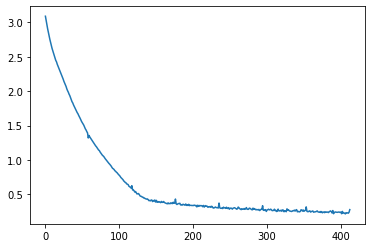

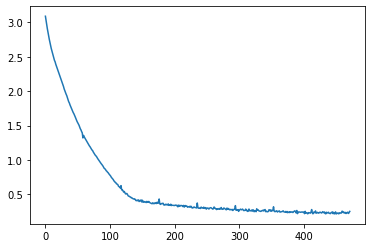

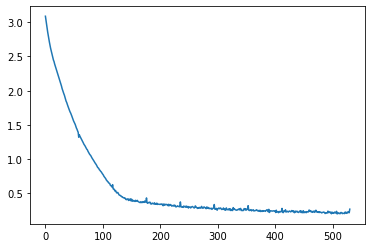

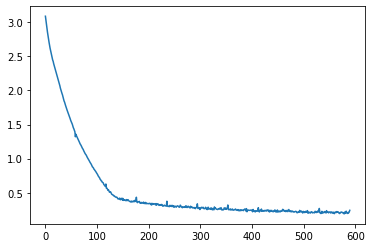

In [ ]:
class MNISTNetwork(nn.Module):
    def __init__(self):
        super(MNISTNetwork, self).__init__()
        '''
        self.network = nn.Sequential(
            # CNN
            nn.Conv2d(1,4,(3,3), stride = 2, bias = False),
            nn.Conv2d(4,8,(3,3), stride = 2, bias = False),
            nn.Conv2d(8,16,(3,3), stride = 2, bias = False),
            nn.Flatten(),
            nn.Linear(64, 8, bias = False))
        '''
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 32, bias = False),
            nn.ReLU(),
            nn.Linear(32, 16, bias = False))
        # just making sure that this remains fixed to prevent trivial solutions
        # e.g. all w = 0, c = 0
        self.c = torch.randn(16, requires_grad = False) 

    def forward(self, x):
        x = self.network(x)
        return torch.linalg.vector_norm(x - self.c, dim = -1), x

device = 'cpu'
epochs = 10
model = MNISTNetwork().to(device)
model.c = model.c.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
losses = []
for epoch in tqdm(range(epochs)):
    for (batch_,_), (batch_anomaly, _) in zip(train_loader, train_loader_anomaly):
        batch = torch.cat((batch_,batch_anomaly))
        l = torch.cat((torch.ones(batch_.shape[0]), -torch.ones(batch_anomaly.shape[0])))

        s = model(batch.to(device))[0]
        loss = (s**l).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.plot(losses)
    plt.show()

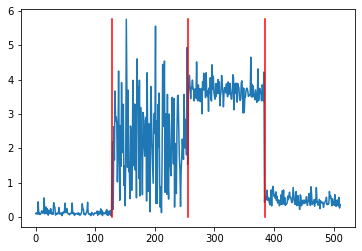

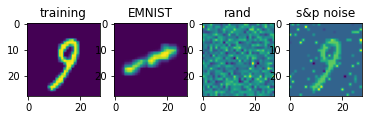

In [ ]:
def salt_and_pepper(x, ratio):
    N = int(ratio * x.numel())
    indices = torch.randint(0,x.numel(),(N,))
    x[indices] = torch.randn(N)
    return x

N = 128
batch_train = next(iter(train_loader))[0][:N]
batch_test = next(iter(train_loader_anomaly))[0][:N]

with torch.no_grad():
    # random noise
    x_random = torch.randn((batch_train.shape[0],1,28,28))
    # salt and pepper
    x_sp = batch_train.clone()
    x_sp = salt_and_pepper(x_sp.ravel(),0.1).reshape(x_sp.shape)
    # EMNIST

    batch_ = torch.cat((batch_train,batch_test, x_random,x_sp))
    s = model(batch_)[0]
    plt.plot(s)
    plt.plot([N,N],[0,s.max()],'r-')
    plt.plot([2*N,2*N],[0,s.max()],'r-')
    plt.plot([3*N,3*N],[0,s.max()],'r-')
    plt.show()

    plt.subplot(141)
    plt.imshow(batch_train[0,0,...])
    plt.title('training')
    plt.subplot(142)
    plt.imshow(batch_test[0,0,...])
    plt.title('EMNIST')
    plt.subplot(143)
    plt.title('rand')
    plt.imshow(x_random[0,0,...])
    plt.subplot(144)
    plt.title('s&p noise')
    plt.imshow(x_sp[0,0,...])